In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, models
import faiss


In [61]:
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

# Using Wiki Dataset

In [62]:
data_wiki = pd.read_csv('wiki_movie_plots_deduped.csv',memory_map=True)
data_wiki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [63]:
import gc
df_wiki = data_wiki[['Title','Plot']]
del data_wiki
gc.collect()

7530

In [64]:
df_wiki

,Title,Plot
0,Kansas Saloon Smashers,"A bartender is working at a saloon, serving dr..."
1,Love by the Light of the Moon,"The moon, painted with a smiling face hangs ov..."
2,The Martyred Presidents,"The film, just over a minute long, is composed..."
3,"Terrible Teddy, the Grizzly King",Lasting just 61 seconds and consisting of two ...
4,Jack and the Beanstalk,The earliest known adaptation of the classic f...
...,...,...
34881,The Water Diviner,"The film begins in 1919, just after World War ..."
34882,Çalgı Çengi İkimiz,"Two musicians, Salih and Gürkan, described the..."
34883,Olanlar Oldu,"Zafer, a sailor living with his mother Döndü i..."
34884,Non-Transferable,The film centres around a young woman named Am...


In [65]:
df_wiki.dropna(inplace=True)
df_wiki.drop_duplicates(subset=['Plot'],inplace=True)

C:\Users\ubaid\AppData\Local\Temp\ipykernel_20324\3868136056.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_wiki['doc_len'], hist=True, kde=True, color='b', label='doc len')


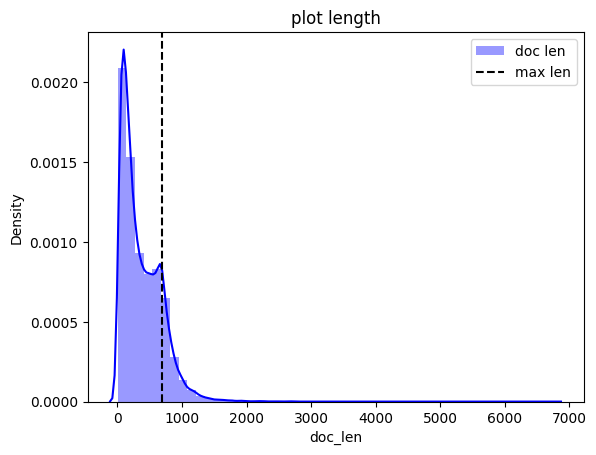

In [66]:
df_wiki['doc_len'] = df_wiki['Plot'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df_wiki['doc_len'].mean() + df_wiki['doc_len'].std()).astype(int)
sns.distplot(df_wiki['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

In [ ]:
import faiss
encoded_data = model.encode(df_wiki.Plot.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df_wiki))))
faiss.write_index(index, 'movie_plot.index')

In [71]:
index = faiss.read_index("movie_plot.index")
index

<faiss.swigfaiss_avx2.IndexIDMap; proxy of <Swig Object of type 'faiss::IndexIDMapTemplate< faiss::Index > *' at 0x000002AF2F831560> >

In [72]:
def fetch_movie_info(dataframe_idx):
    info = df_wiki.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['Title'] = info['Title']
    return meta_dict
    
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [73]:
from pprint import pprint

query="Artificial Intelligence based action movie"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.017039060592651367


	 {'Title': 'The Cape Canaveral Monsters'}
	 {'Title': 'Small Soldiers'}
	 {'Title': 'Chappie'}
	 {'Title': 'Armed Response'}
	 {'Title': 'Galactic Armored Fleet Majestic Prince: Genetic Awakening'}


In [74]:
from pprint import pprint

query="movie about romance and pain of separation"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',(result))

>>>> Results in Total Time: 0.019429445266723633


	 {'Title': 'Look Both Ways'}
	 {'Title': 'Young People Fucking'}
	 {'Title': 'About Love'}
	 {'Title': 'Brothers'}
	 {'Title': 'The Farm: En Veettu Thottathil'}


In [75]:
paragraphs=df_wiki.Plot.tolist()

# Using Quran Dataset

In [12]:
data = pd.read_csv('../quran_id_full.csv',memory_map=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6236 entries, 0 to 6235
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6236 non-null   int64 
 1   suraId    6236 non-null   int64 
 2   verseID   6236 non-null   int64 
 3   ayahText  6236 non-null   object
 4   indoText  6236 non-null   object
 5   readText  6236 non-null   object
dtypes: int64(3), object(3)
memory usage: 292.4+ KB


In [13]:
import gc
df_quran = data[['id', 'suraId', 'verseID', 'indoText']]
del data
gc.collect()

2162

In [81]:
df_quran

,id,suraId,verseID,indoText
0,0,1,1,"Dengan nama Allah Yang Maha Pengasih, Maha Pen..."
1,1,1,2,"Segala puji bagi Allah, Tuhan seluruh alam,"
2,2,1,3,"Yang Maha Pengasih, Maha Penyayang,"
3,3,1,4,Pemilik hari pembalasan.
4,4,1,5,Hanya kepada Engkaulah kami menyembah dan hany...
...,...,...,...,...
6231,6231,114,2,"Raja manusia,"
6232,6232,114,3,"sembahan manusia,"
6233,6233,114,4,"dari kejahatan (bisikan) setan yang bersembunyi,"
6234,6234,114,5,yang membisikkan (kejahatan) ke dalam dada man...


C:\Users\ubaid\AppData\Local\Temp\ipykernel_20324\478102837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_quran['doc_len'], hist=True, kde=True, color='b', label='doc len')


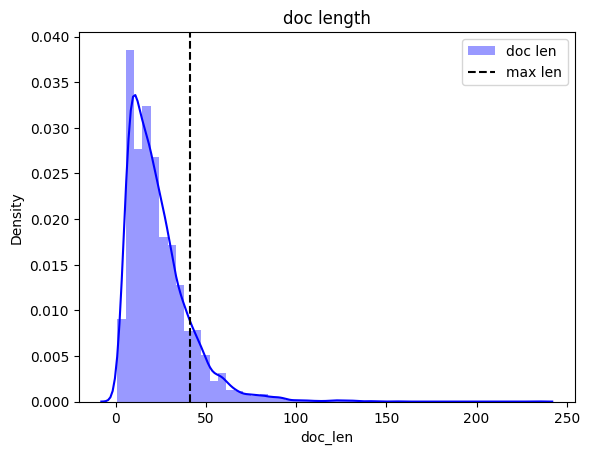

In [82]:
df_quran['doc_len'] = df_quran['indoText'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df_quran['doc_len'].mean() + df_quran['doc_len'].std()).astype(int)
sns.distplot(df_quran['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('doc length'); plt.legend()
plt.show()

In [ ]:
# store embeded doc to faiss
encoded_data = model.encode(df_quran.indoText.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df_quran))))
faiss.write_index(index, 'quran_embed.index')

In [84]:
index = faiss.read_index("quran_embed.index")

In [15]:
def fetch_ayat_info(dataframe_idx):
    info = df_quran.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['no_surat'] = info['suraId']
    meta_dict['no_ayat'] = info['verseID']
    meta_dict['teks'] = info['indoText']
    return meta_dict
    
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print(top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_ayat_info(idx) for idx in top_k_ids]
    return results

In [86]:
from pprint import pprint

query="apa itu tuhan yang maha esa"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.010007143020629883


	 {'no_surat': np.int64(12), 'no_ayat': np.int64(40), 'teks': 'Apa yang kamu sembah selain Dia, hanyalah nama-nama yang kamu buat-buat baik oleh kamu sendiri maupun oleh nenek moyangmu. Allah tidak menurunkan suatu keterangan pun tentang hal (nama-nama) itu. Keputusan itu hanyalah milik Allah. Dia telah memerintahkan agar kamu tidak menyembah selain Dia. Itulah agama yang lurus, tetapi kebanyakan manusia tidak mengetahui.'}
	 {'no_surat': np.int64(13), 'no_ayat': np.int64(33), 'teks': 'Maka apakah Tuhan yang menjaga setiap jiwa terhadap apa yang diperbuatnya (sama dengan yang lain)? Mereka menjadikan sekutu-sekutu bagi Allah. Katakanlah, “Sebutkanlah sifat-sifat mereka itu.” Atau apakah kamu hendak memberitahukan kepada Allah apa yang tidak diketahui-Nya di bumi, atau (mengatakan tentang hal itu) sekedar perkataan pada lahirnya saja. Sebenarnya bagi orang kafir, tipu daya mereka itu dijadikan terasa indah, dan mereka dihalangi dari jal

In [57]:
index = faiss.read_index("quran_embed.index")

# Bi Encoder FineTune

In [16]:
# Now we create a SentenceTransformer model from scratch
word_emb = models.Transformer('sentence-transformers/msmarco-distilbert-base-dot-prod-v3')
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])

In [18]:
import torch
#Select the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [27]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets
from torch import nn
import os

df = pd.read_csv('qa_id.csv', sep='\t')

train_examples = [
    InputExample(texts=[row['question_id'], row['answer_id']])
    for _, row in df.iterrows()
]


In [28]:
df

,idx,question_id,answer_id
0,0,Apa satu - satunya buku yang bebas dari keragu...,(Kitab ini) yakni yang dibaca oleh Muhammad sa...
1,1,"(Apakah buah-buahan di surga) maksudnya, buah-...",(Dan sampaikanlah berita gembira) kabarkanlah ...
2,2,Berapa banyak kematian dan berapa banyak nyawa...,"Setelah itu, Dia menghidupkan kalian lagi untu..."
3,3,Berapa banyak surga yang ada?,(Dialah yang telah menciptakan bagimu segala y...
4,4,Adam tidak pernah disentuh oleh malaikat kecua...,(Dan diajarkan-Nya kepada Adam nama-nama) maks...
...,...,...,...
1219,1219,Sesungguhnya Ibrahim itu benar-benar seorang y...,Sesungguhnya di antara yang mengikuti jejak da...
1220,1220,Nabi Luth merasa takut kaumnya akan melakukan ...,(Maka Yusuf berlaku takabur terhadap mereka ka...
1221,1221,(Mengapa) lafal Bal di sini menunjukkan makna ...,Jika aku mempunyai kekuatan dan dukungan dari ...
1222,1222,(Dan Yusuf berkata kepada pembantu-pembantunya...,(Yusuf berkata kepada pembantu-pembantunya) me...


In [30]:

# For the MultipleNegativesRankingLoss, it is important
# that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs.
# To ensure this, we use a special data loader
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=8)
# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss = losses.MultipleNegativesRankingLoss(model)

In [32]:
#Tune the model
num_epochs = 3
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=num_epochs, warmup_steps=warmup_steps, show_progress_bar=True)

os.makedirs('search', exist_ok=True)
model.save('search/search-model')

Step,Training Loss


# Test Model Fine Tune

In [ ]:
model_finetune = SentenceTransformer('search/search-model')

In [88]:
import faiss
encoded_data = model_finetune.encode(df_quran.indoText.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df_quran))))
faiss.write_index(index, 'quran_embed_finetune.index')

In [6]:
import faiss
index_finetune = faiss.read_index("quran_embed_finetune.index")

In [16]:
from pprint import pprint

query="apa itu tuhan yang maha esa"
results=search(query, top_k=5, index=index_finetune, model=model_finetune)

print("\n")
for result in results:
    print('\t',result)

(array([[113.29738 , 109.290405, 107.11948 , 104.61417 , 104.19116 ]],
      dtype=float32), array([[1922, 3946, 6221,  169, 5948]]))
>>>> Results in Total Time: 0.013046026229858398


	 {'no_surat': np.int64(2), 'no_ayat': np.int64(163), 'teks': 'Dan Tuhan kamu adalah Tuhan Yang Maha Esa, tidak ada tuhan selain Dia, Yang Maha Pengasih, Maha Penyayang.'}
	 {'no_surat': np.int64(16), 'no_ayat': np.int64(22), 'teks': 'Tuhan kamu adalah Tuhan Yang Maha Esa. Maka orang yang tidak beriman kepada akhirat, hati mereka mengingkari (keesaan Allah), dan mereka adalah orang yang sombong.'}
	 {'no_surat': np.int64(37), 'no_ayat': np.int64(159), 'teks': 'Mahasuci Allah dari apa yang mereka sifatkan,'}
	 {'no_surat': np.int64(87), 'no_ayat': np.int64(1), 'teks': 'Sucikanlah nama Tuhanmu Yang Mahatinggi,'}
	 {'no_surat': np.int64(112), 'no_ayat': np.int64(1), 'teks': 'Katakanlah (Muhammad), “Dialah Allah, Yang Maha Esa.'}


# Query Sintetic

In [15]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
tokenizer = T5Tokenizer.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model = T5ForConditionalGeneration.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model.eval()

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (

In [16]:
#Select the device
device = 'cuda'
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (

In [17]:
# Parameters for generation
batch_size = 16 #Batch size
num_queries = 5 #Number of queries to generate for every paragraph
max_length_paragraph = 512 #Max length for paragraph
max_length_query = 64   #Max length for output query

In [18]:
def _removeNonAscii(s): return "".join(i for i in s if ord(i) < 128)

In [19]:
# with open('generated_queries_all.tsv', 'w') as fOut:
#     for start_idx in tqdm(range(0, len(paragraphs), batch_size)):
#         sub_paragraphs = paragraphs[start_idx:start_idx+batch_size]
#         inputs = tokenizer.prepare_seq2seq_batch(sub_paragraphs, max_length=max_length_paragraph, truncation=True, return_tensors='pt').to(device)
#         outputs = model.generate(
#             **inputs,
#             max_length=max_length_query,
#             do_sample=True,
#             top_p=0.95,
#             num_return_sequences=num_queries)

#         for idx, out in enumerate(outputs):
#             query = tokenizer.decode(out, skip_special_tokens=True)
#             query = _removeNonAscii(query)
#             para = sub_paragraphs[int(idx/num_queries)]
#             para = _removeNonAscii(para)
#             fOut.write("{}\t{}\n".format(query.replace("\t", " ").strip(), para.replace("\t", " ").strip()))

In [20]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets
from torch import nn
import os
import random

train_examples = [] 
with open('../input/user-query-data/generated_queries_all (1).tsv') as fIn:
    for line in fIn:
        try:
            query, paragraph = line.strip().split('\t', maxsplit=1)
            train_examples.append(InputExample(texts=[query, paragraph]))
        except:
            pass
        
random.shuffle(train_examples)

# For the MultipleNegativesRankingLoss, it is important
# that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs.
# To ensure this, we use a special data loader
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=8)

# Now we create a SentenceTransformer model from scratch
word_emb = models.Transformer('sentence-transformers/msmarco-distilbert-base-dot-prod-v3')
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])


# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss = losses.MultipleNegativesRankingLoss(model)


#Tune the model
num_epochs = 3
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=num_epochs, warmup_steps=warmup_steps, show_progress_bar=True)

os.makedirs('search', exist_ok=True)
model.save('search/search-model')

Downloading:   0%|          | 0.00/632 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/454 [00:00<?, ?B/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/21168 [00:00<?, ?it/s]

Iteration:   0%|          | 0/21168 [00:00<?, ?it/s]

Iteration:   0%|          | 0/21168 [00:00<?, ?it/s]

In [21]:
from sentence_transformers import SentenceTransformer, util
import gzip
import json
import os

model = SentenceTransformer('search/search-model')

In [22]:
!zip -r search_model.zip "./search"

  adding: search/ (stored 0%)
  adding: search/search-model/ (stored 0%)
  adding: search/search-model/modules.json (deflated 55%)
  adding: search/search-model/0_Transformer/ (stored 0%)
  adding: search/search-model/0_Transformer/pytorch_model.bin (deflated 8%)
  adding: search/search-model/0_Transformer/sentence_bert_config.json (deflated 4%)
  adding: search/search-model/0_Transformer/special_tokens_map.json (deflated 40%)
  adding: search/search-model/0_Transformer/tokenizer_config.json (deflated 39%)
  adding: search/search-model/0_Transformer/vocab.txt (deflated 53%)
  adding: search/search-model/0_Transformer/config.json (deflated 43%)
  adding: search/search-model/1_Pooling/ (stored 0%)
  adding: search/search-model/1_Pooling/config.json (deflated 47%)
  adding: search/search-model/config.json (stored 0%)


In [23]:
import faiss
encoded_data = model.encode(df.Plot.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index, 'movie_plot.index')

Batches:   0%|          | 0/1059 [00:00<?, ?it/s]

In [24]:
from pprint import pprint

query="Artificial Intelligence based action movie"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

>>>> Results in Total Time: 0.0754389762878418


	 {'Title': 'Remote Control'}
	 {'Title': 'Armed Response'}
	 {'Title': 'Crosstalk'}
	 {'Title': 'The Machine'}
	 {'Title': 'Robot Overlords'}


In [25]:
from pprint import pprint

query="movie about romance and pain of seperation"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

>>>> Results in Total Time: 0.07534384727478027


	 {'Title': 'In Love We Trust'}
	 {'Title': 'Manasina Maathu'}
	 {'Title': 'Murali Meets Meera'}
	 {'Title': 'Prem Mhanje Prem Mhanje Prem Asta'}
	 {'Title': 'Intentions of Murder'}
